In [1]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import py3dep
import shapely
from shapely.geometry import box
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/old/052_2021-02-03_2021-02-10.nc')
ds = ds['cor'].sel(band = 'VV').coarsen(x = 100, boundary = 'pad').mean().coarsen(y = 100, boundary = 'pad').mean()

geom = ds.rio.bounds()
hs = py3dep.get_map("Hillshade Gray", geom, resolution=30, geo_crs="epsg:4326", crs="epsg:4326")

states = gpd.read_file('/bsuhome/zacharykeskinen/uavsar-validation/data/states/tl_2021_us_state.shp')

insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_insitu.parq')
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat))
insitu = insitu.set_crs('EPSG:4326')
gdf = insitu

# lidars = []
# lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')
# for lidar_fp in lidar_dir.glob('*.nc'):
#     if '.all' in lidar_fp.name or '.sd' in lidar_fp.name:
#         continue

#     lidar = xr.open_dataset(lidar_fp).isel(time = 0)
#     lidar = lidar.rio.reproject_match(hs)
#     lidars.append(lidar['lidar-sd'])

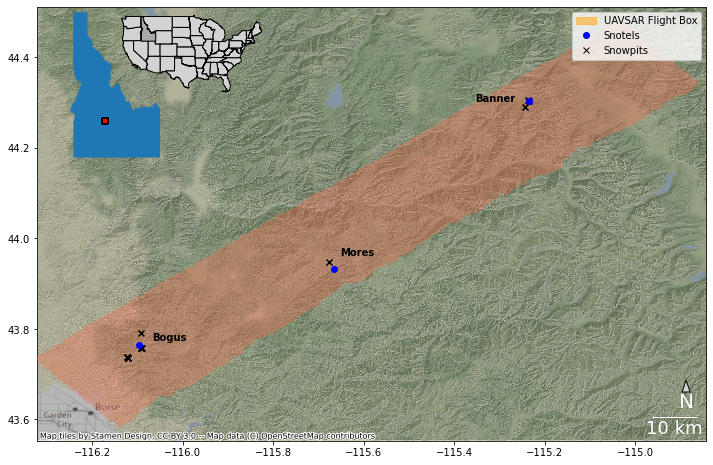

In [5]:
f, ax = plt.subplots(figsize=(12, 10))

# MAKE INSET MAP
ax2 = inset_axes(ax, "35%", "35%", loc="upper left")
geo_states = states.to_crs(epsg = 3857)
geo_states[(geo_states['NAME'] != 'Hawaii') & (geo_states['NAME'] != 'Puerto Rico')].plot(facecolor = 'lightgrey', edgecolor = 'black', ax= ax2)
ID = geo_states[geo_states['NAME'] == 'Idaho'].geometry
ID.plot(facecolor = 'darkgrey', edgecolor = 'black', ax = ax2)
ID_shift = ID.apply(lambda x: shapely.affinity.translate(x, xoff=-1.5e6, yoff=-2.6e6))
ID_shift = ID_shift.apply(lambda x: shapely.affinity.scale(x, xfact= 6, yfact = 6))
ID_shift.plot(ax = ax2)
ax2.set_xlim([-1.7e7, -7400000])
ax2.set_ylim([-0.05e7, 6500000])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
shift = gdf.geometry.to_crs(epsg = 3857)
shift = shift.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=-1.8e6, yoff=-4e6))
geom = gpd.GeoSeries(shift).total_bounds
geom = tuple(geom)
geom = [x + y for x, y in zip(list(geom), [-0.1e6, -.1e6, .1e6, .1e6])]
bbox = box(*geom)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 2, facecolor = 'red', edgecolor = 'black')
ax2.axis('off')

# MAKE MAIN MAP

# plot hill shading
hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar = False)

# plot insitu data
insitu.loc[insitu.datasource == 'SnowEx'].drop_duplicates('site_name').plot(ax = ax, zorder = 4, color = 'black', marker = 'x', label = 'Snowpits')

insitu.loc[(insitu.site_name != 'jackson') & (insitu.datasource == 'NRCS')].drop_duplicates('site_name').plot(ax = ax, zorder = 4, color = 'blue', marker = 'o', label = 'Snotels')

# for lidar in lidars:
    # lidar.where(lidar.isnull(), 1).plot(ax = ax, add_colorbar = False, cmap = 'Purples', zorder = 3, alpha = 0.75, vmin = 0, vmax = 1)

# plot uavsar bounding box
ds.where(ds.isnull(), 1).plot(alpha = 0.35, cmap = 'Reds', add_colorbar = False, ax = ax, zorder = 3)

# plot stamen topo map
ctx.add_basemap(ax, crs = 'EPSG:4326', source = ctx.providers.Stamen.Terrain, alpha = .65, zorder = 2)


ax.set(xlabel = None)
ax.set(ylabel = None)

# North Arrow
x, y, arrow_length = 0.97, 0.14, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='lightgrey', width=3, headwidth=8),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes, color = 'white')

# scale bar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           0.1, '10 km', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=0.001,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# legend
uavsar_lg = mpatches.Patch(color='orange', alpha = 0.5, label='UAVSAR Flight Box')
# lidar_lg = mpatches.Patch(color='purple', alpha = 0.65, label='LiDAR Flight Boxes')
snotel_lg = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='Snotels')
snowpit_lg = mlines.Line2D([], [], color='black', marker='x', linestyle='None', label='Snowpits')

ax.legend(handles=[uavsar_lg, snotel_lg, snowpit_lg], loc = 'upper right')

# site names
for i, r in insitu.loc[(insitu.site_name != 'jackson') & (insitu.datasource == 'NRCS')].drop_duplicates('site_name').iterrows():
    bx, by = (0.03, 0.01)
    if r.site_name == 'mores':
        bx, by = (0.0145, 0.03)
    if r.site_name == 'banner':
        bx, by = (-0.12, 0)
    ax.text(x = r.lon + bx, y = r.lat + by, s = r.site_name.capitalize(), weight='bold')

ax.set_title('')

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/study_area/study_area_map_v2.png')

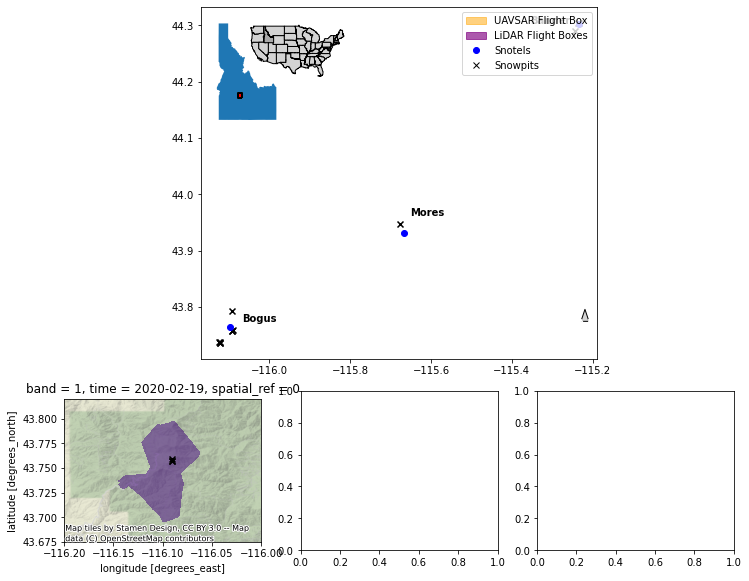

In [79]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 10))

gs = GridSpec(3, 3, figure=fig)
ax = fig.add_subplot(gs[:2, :])
ax_bogus = fig.add_subplot(gs[2, 0])
ax_mores = fig.add_subplot(gs[2, 1])
ax_banner = fig.add_subplot(gs[2, 2])

axes = [ax_bogus, ax_mores, ax_banner]
# MAKE INSET MAP
ax2 = inset_axes(ax, "35%", "35%", loc="upper left")
geo_states = states.to_crs(epsg = 3857)
geo_states[(geo_states['NAME'] != 'Hawaii') & (geo_states['NAME'] != 'Puerto Rico')].plot(facecolor = 'lightgrey', edgecolor = 'black', ax= ax2)
ID = geo_states[geo_states['NAME'] == 'Idaho'].geometry
ID.plot(facecolor = 'darkgrey', edgecolor = 'black', ax = ax2)
ID_shift = ID.apply(lambda x: shapely.affinity.translate(x, xoff=-1.5e6, yoff=-2.6e6))
ID_shift = ID_shift.apply(lambda x: shapely.affinity.scale(x, xfact= 6, yfact = 6))
ID_shift.plot(ax = ax2)
ax2.set_xlim([-1.7e7, -7400000])
ax2.set_ylim([-0.05e7, 6500000])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
shift = gdf.geometry.to_crs(epsg = 3857)
shift = shift.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=-1.8e6, yoff=-4e6))
geom = gpd.GeoSeries(shift).total_bounds
geom = tuple(geom)
geom = [x + y for x, y in zip(list(geom), [-0.1e6, -.1e6, .1e6, .1e6])]
bbox = box(*geom)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 2, facecolor = 'red', edgecolor = 'black')
ax2.axis('off')

# # MAKE MAIN MAP

# plot hill shading
# hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar = False)

# plot insitu data
insitu.loc[insitu.datasource == 'SnowEx'].drop_duplicates('site_name').plot(ax = ax, zorder = 4, color = 'black', marker = 'x', label = 'Snowpits')

insitu.loc[(insitu.site_name != 'jackson') & (insitu.datasource == 'NRCS')].drop_duplicates('site_name').plot(ax = ax, zorder = 4, color = 'blue', marker = 'o', label = 'Snotels')

# for lidar in lidars:
    # lidar.where(lidar.isnull(), 1).plot(ax = ax, add_colorbar = False, cmap = 'Purples', zorder = 3, alpha = 0.75, vmin = 0, vmax = 1)

# # plot uavsar bounding box
# ds.where(ds.isnull(), 1).plot(alpha = 0.35, cmap = 'Reds', add_colorbar = False, ax = ax, zorder = 3)

# plot stamen topo map
# ctx.add_basemap(ax, crs = 'EPSG:4326', source = ctx.providers.Stamen.Terrain, alpha = .65, zorder = 2)

ax.set(xlabel = None)
ax.set(ylabel = None)

# North Arrow
x, y, arrow_length = 0.97, 0.14, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='lightgrey', width=3, headwidth=8),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes, color = 'white')

# scale bar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           0.1, '10 km', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=0.001,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# legend
uavsar_lg = mpatches.Patch(color='orange', alpha = 0.5, label='UAVSAR Flight Box')
lidar_lg = mpatches.Patch(color='purple', alpha = 0.65, label='LiDAR Flight Boxes')
snotel_lg = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='Snotels')
snowpit_lg = mlines.Line2D([], [], color='black', marker='x', linestyle='None', label='Snowpits')

ax.legend(handles=[uavsar_lg, lidar_lg, snotel_lg, snowpit_lg], loc = 'upper right')

# site names
for i, r in insitu.loc[(insitu.site_name != 'jackson') & (insitu.datasource == 'NRCS')].drop_duplicates('site_name').iterrows():
    bx, by = (0.03, 0.01)
    if r.site_name == 'mores':
        bx, by = (0.0145, 0.03)
    if r.site_name == 'banner':
        bx, by = (-0.12, 0)
    ax.text(x = r.lon + bx, y = r.lat + by, s = r.site_name.capitalize(), weight='bold')

ax.set_title('')

## inset site plots
pits = insitu.loc[insitu.datasource == 'SnowEx']

# Bogus Basin
ax_bogus.set_title('Bogus')

pits[pits.site_name.str.contains('Bogus')].drop_duplicates('site_name').plot(ax = ax_bogus, zorder = 4, color = 'black', marker = 'x', label = '_Snowpits')
lidars[2].where(lidars[2].isnull(), 1).plot(ax = ax_bogus, add_colorbar = False, cmap = 'Purples', zorder = 3, alpha = 0.5, vmin = 0, vmax = 1)
ax_bogus.set_xlim(-116.2, -116)
ax_bogus.set_ylim(43.675, 43.82)
ctx.add_basemap(ax_bogus, crs = 'EPSG:4326', source = ctx.providers.Stamen.Terrain, alpha = .65, zorder = 2)

# plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/study_area/study_area_map_v2.png')

# setting up interval data

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
from shapely.geometry import LineString

import matplotlib.pyplot as plt

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from constants import tol

ncs_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs')
ds = xr.open_dataset(ncs_dir.joinpath('final_10_10.nc'))#.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

if not ds.rio.crs:
    ds = ds.rio.write_crs('EPSG:4326')

# ds = ds.where(ds['cor'] > 0.45)

interval = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/storm_boards.parq')
interval = gpd.GeoDataFrame(interval, geometry = gpd.points_from_xy(interval.longitude, interval.latitude), crs="EPSG:4326")

insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

# get insitu info
densities = np.zeros(len(ds.time1.data))
phases = np.zeros(len(ds.time1.data))
for i, time in enumerate(ds.time1.data):
    insitu_t = insitu[insitu.time1 == time]
    density = np.mean(insitu_t[['t1_density', 't2_density']].mean(axis = 1))
    densities[i] = density
    phases[i] = np.mean(phase_from_depth(insitu_t['dSWE']*997/density, insitu_t['inc'], density = insitu_t[['t1_density', 't2_density']].mean(axis = 1)))
densities = xr.DataArray(densities,
    coords = {'time1':ds.time1.data})
phases = xr.DataArray(phases,
    coords = {'time1':ds.time1.data})

ds['unw_atm'] = ds['unw'] - ds['delay']
ds['unw_atm'] = ds['unw_atm'] - (ds['unw_atm'].mean(dim = ['x','y']) - phases)
# ds['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - sub['model_d_swe'].mean(dim = ['x','y']))
unw_d_swe = depth_from_phase(ds['unw_atm'], ds['inc'], density = densities) * densities / 997
unw_d_sd = depth_from_phase(ds['unw_atm'], ds['inc'], density = densities)

for i, r in interval.iterrows():
    try:
        uv_t = unw_d_swe.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
        uv_t_sd = unw_d_sd.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
        ds_t = ds.sel(time1 = r.date_t1, method = 'nearest', tolerance = '3 days')
    except KeyError:
        continue

    interval.loc[i, 'near_uv_swe'] = uv_t.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = tol)
    interval.loc[i, 'near_uv_sd'] = uv_t_sd.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest', tolerance = tol)
    x_slice = slice(r.geometry.x - 2*tol, r.geometry.x + 2*tol)
    y_slice = slice(r.geometry.y + 2*tol, r.geometry.y - 2*tol)
    interval.loc[i, 'uv_swe'] = uv_t_sd.sel(x = x_slice, y = y_slice).mean() * r.den / 997
    interval.loc[i, 'uv_sd'] = uv_t_sd.sel(x = x_slice, y = y_slice).mean()
    interval.loc[i, 'model_melt'] = ds_t.sel(x = x_slice, y = y_slice)['cum_melt'].mean()
    interval.loc[i, 'cor'] = ds_t.sel(x = x_slice, y = y_slice)['cor'].mean()
    interval.loc[i, 'tree'] = ds_t.sel(x = x_slice, y = y_slice)['tree_perc'].mean()

import contextily as ctx

site_id = 'LR'
boards = interval[interval.site.str.contains(site_id)]
boards = boards.sort_values('elev_meters')

boards = boards[['swe','elev_meters','date_t2','date_t1','geometry']]

t1 = pd.to_datetime('2021-02-03')
t2 = pd.to_datetime('2021-02-10')

flight_boards = boards.loc[(boards.date_t2 <= t2 + pd.Timedelta('2 days')) & (boards.date_t1 >= t1 - pd.Timedelta('2 days')), :].copy()
geom = []
for g1, g2 in zip(flight_boards.geometry.iloc[:-1], flight_boards.geometry.iloc[1:]):
    geom.append(LineString([g1, g2]))
buffer = gpd.GeoDataFrame({'geometry':geom})
buffer = buffer.buffer(10*tol)

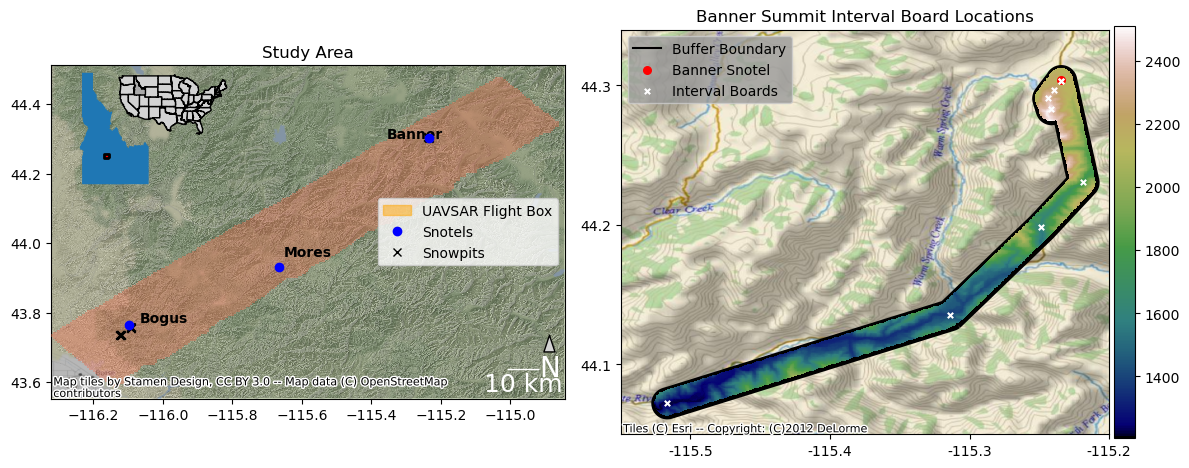

In [15]:
ds = xr.open_dataset(ncs_dir.joinpath('final_10_10.nc'))#.isel(x = slice(0, -1, 10), y = slice(0, -1, 10))

if not ds.rio.crs:
    ds = ds.rio.write_crs('EPSG:4326')

fig, axes = plt.subplots(1, 2, figsize = (12, 8))

ax = axes[1]

gpd.GeoSeries(buffer.unary_union).plot(color = None, edgecolor='k', linewidth = 5, facecolor = None, ax = ax)
plt.plot([0,0],[0,0], color = 'k', label = 'Buffer Boundary')

ds['dem'].rio.clip(buffer.geometry.values, crs= 'EPSG:4326').plot(ax = ax, cmap = 'gist_earth', add_colorbar = True, cbar_kwargs = {'fraction': 0.04, 'pad': 0.01, 'label': ''})

x, y = insitu[insitu['site_name'] == 'Banner Snotel'].iloc[0].geometry.xy
ax.scatter(x, y, label = 'Banner Snotel', color = 'red', s = 30)

flight_boards.plot(ax = ax, marker = 'x', color = 'white', markersize = 15, label = 'Interval Boards')

ax.set_xlim(-115.55, -115.2)
ax.set_ylim(44.05, 44.34)
ax.set_xticks([-115.5, -115.4, -115.3, -115.2], ['-115.5', '-115.4', '-115.3', '-115.2'])
ax.set_yticks([44.1, 44.2, 44.3], ['44.1', '44.2', '44.3'])

ax.set_xlabel('')
ax.set_ylabel('')

ax.legend(loc = 'upper left', facecolor = '0.6')

ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source= ctx.providers.Esri.DeLorme, zoom = 11)

ax.set_title('Banner Summit Interval Board Locations')

# second main image
ax = axes[0]

# MAKE INSET MAP
ax2 = inset_axes(ax, "35%", "35%", loc="upper left")
geo_states = states.to_crs(epsg = 3857)
geo_states[(geo_states['NAME'] != 'Hawaii') & (geo_states['NAME'] != 'Puerto Rico')].plot(facecolor = 'lightgrey', edgecolor = 'black', ax= ax2)
ID = geo_states[geo_states['NAME'] == 'Idaho'].geometry
ID.plot(facecolor = 'darkgrey', edgecolor = 'black', ax = ax2)
ID_shift = ID.apply(lambda x: shapely.affinity.translate(x, xoff=-1.5e6, yoff=-2.6e6))
ID_shift = ID_shift.apply(lambda x: shapely.affinity.scale(x, xfact= 6, yfact = 6))
ID_shift.plot(ax = ax2)
ax2.set_xlim([-1.7e7, -7400000])
ax2.set_ylim([-0.05e7, 6500000])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
shift = gdf.geometry.to_crs(epsg = 3857)
shift = shift.geometry.apply(lambda x: shapely.affinity.translate(x, xoff=-1.8e6, yoff=-4e6))
geom = gpd.GeoSeries(shift).total_bounds
geom = tuple(geom)
geom = [x + y for x, y in zip(list(geom), [-0.1e6, -.1e6, .1e6, .1e6])]
bbox = box(*geom)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 2, facecolor = 'red', edgecolor = 'black')
ax2.axis('off')

# MAKE MAIN MAP

# plot hill shading
hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar = False)

# plot insitu data
insitu.loc[insitu.datasource == 'SnowEx'].drop_duplicates('site_name').plot(ax = ax, zorder = 4, color = 'black', marker = 'x', label = 'Snowpits')

insitu.loc[(insitu.site_name != 'jackson') & (insitu.datasource == 'NRCS')].drop_duplicates('site_name').plot(ax = ax, zorder = 4, color = 'blue', marker = 'o', label = 'Snotels')

# plot uavsar bounding box
ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/old/052_2021-02-03_2021-02-10.nc')
ds = ds['cor'].sel(band = 'VV').coarsen(x = 100, boundary = 'pad').mean().coarsen(y = 100, boundary = 'pad').mean()

ds.where(ds.isnull(), 1).plot(alpha = 0.35, cmap = 'Reds', add_colorbar = False, ax = ax, zorder = 3)

# plot stamen topo map
ctx.add_basemap(ax, crs = 'EPSG:4326', source = ctx.providers.Stamen.Terrain, alpha = .65, zorder = 2)


ax.set(xlabel = None)
ax.set(ylabel = None)

# North Arrow
x, y, arrow_length = 0.97, 0.19, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='lightgrey', width=3, headwidth=8),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes, color = 'white')

# scale bar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           tol*100, '10 km', 'lower right', 
                           pad=0.001,
                           color='white',
                           frameon=False,
                           size_vertical=0.0001,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# legend
uavsar_lg = mpatches.Patch(color='orange', alpha = 0.5, label='UAVSAR Flight Box')
# lidar_lg = mpatches.Patch(color='purple', alpha = 0.65, label='LiDAR Flight Boxes')
snotel_lg = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', label='Snotels')
snowpit_lg = mlines.Line2D([], [], color='black', marker='x', linestyle='None', label='Snowpits')

ax.legend(handles=[uavsar_lg, snotel_lg, snowpit_lg], loc = 'center right')

# site names
for i, r in insitu.loc[(insitu.site_name != 'jackson') & (insitu.datasource == 'NRCS')].drop_duplicates('site_name').iterrows():
    bx, by = (0.03, 0.01)
    if r.site_name == 'mores':
        bx, by = (0.0145, 0.03)
    if r.site_name == 'banner':
        bx, by = (-0.12, 0)
    ax.text(x = r.lon + bx, y = r.lat + by, s = r.site_name.capitalize(), weight='bold')

ax.set_title('Study Area')
plt.tight_layout()
# plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/interval/main_map_v1.png')